In [1]:
import torch
torch.cuda.empty_cache()
import numpy as np
from PIL import Image
import matplotlib

from hr_dv2 import HighResDV2
import hr_dv2.transform as tr
from hr_dv2.utils import *

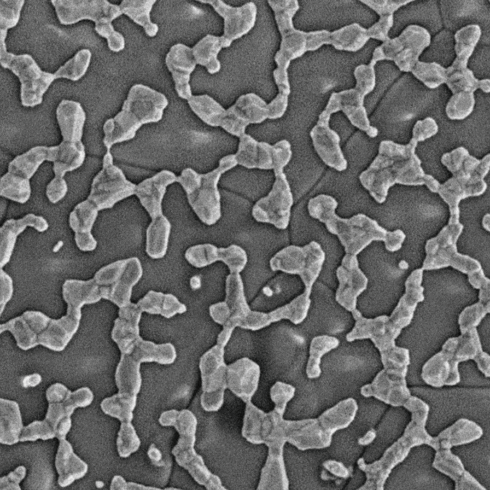

In [2]:
IMG_SIZE = 350 + 70 + 70 #280 - 14 * 5
PATCH_SIZE = 4
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384


transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)

test_tensor, test_img = tr.load_image("data/sofc.jpg", transform)
test_tensor = test_tensor.to(torch.float16)
test_tensor = test_tensor.to('cuda')
test_img

In [3]:
net = HighResDV2("dinov2_vits14_reg", PATCH_SIZE, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
shift_dists = [2]
fwd_shifts, inv_shifts = tr.get_shift_transforms(shift_dists, 'Neumann')
fwd_flips, inv_flips = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_flips, fwd_shifts, inv_flips, inv_shifts)
net.set_transforms(fwd, inv)
hy_features, lr_features = net.forward(test_tensor)

In [5]:
feat_arr_hr = tr.to_numpy(hy_features)
feat_arr_hr = feat_arr_hr.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
feat_arr_hr = feat_arr_hr.T
print(feat_arr_hr.shape)

(240100, 384)


In [6]:
pca = PCA(n_components=6, svd_solver='randomized', n_oversamples=5, iterated_power=3)
pca.fit(feat_arr_hr)
projection = pca.transform(feat_arr_hr)
print(projection.shape)

(240100, 6)


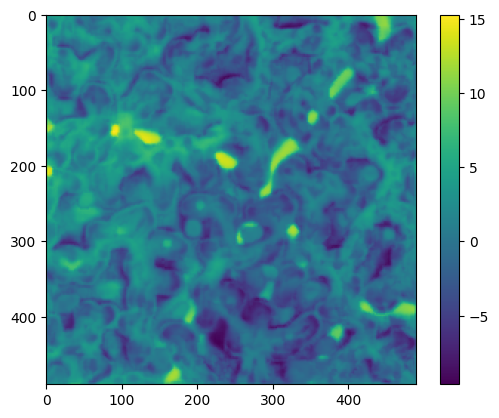

In [13]:
import matplotlib.pyplot as plt
plt.imshow(projection.T[5].reshape(IMG_SIZE, IMG_SIZE))
plt.colorbar()